In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Add src to path so we can import our clean code
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_processing import merge_fraud_data_with_geolocation

In [3]:
# Load Data
print("Loading data...")
fraud_df = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_country_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

Loading data...


In [4]:
# --- TASK 1a: Explicit Data Cleaning & Analysis ---

# 1. Check for Missing Values
print("Missing Values Analysis:")
print(fraud_df.isnull().sum())

# 2. Check for Duplicates
duplicates = fraud_df.duplicated().sum()
print(f"\nDuplicate Rows Found: {duplicates}")

# 3. Check Data Types before conversion
print("\nData Types (Raw):")
print(fraud_df.dtypes)

# 4. Univariate Analysis: Class Imbalance
class_counts = fraud_df['class'].value_counts()
print(f"\nClass Distribution:\n{class_counts}")
print(f"Fraud Rate: {(class_counts[1]/len(fraud_df))*100:.3f}%")

Missing Values Analysis:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Duplicate Rows Found: 0

Data Types (Raw):
user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

Class Distribution:
class
0    136961
1     14151
Name: count, dtype: int64
Fraud Rate: 9.365%


In [5]:
# Use our src function (Best Practice!)
merged_df = merge_fraud_data_with_geolocation(fraud_df, ip_country_df)

Converting IPs to integers...
Merging data (this may take a moment)...


In [6]:
# Feature Engineering
merged_df['signup_time'] = pd.to_datetime(merged_df['signup_time'])
merged_df['purchase_time'] = pd.to_datetime(merged_df['purchase_time'])
merged_df['time_since_signup'] = (merged_df['purchase_time'] - merged_df['signup_time']).dt.total_seconds()
merged_df['hour_of_day'] = merged_df['purchase_time'].dt.hour
merged_df['day_of_week'] = merged_df['purchase_time'].dt.dayofweek

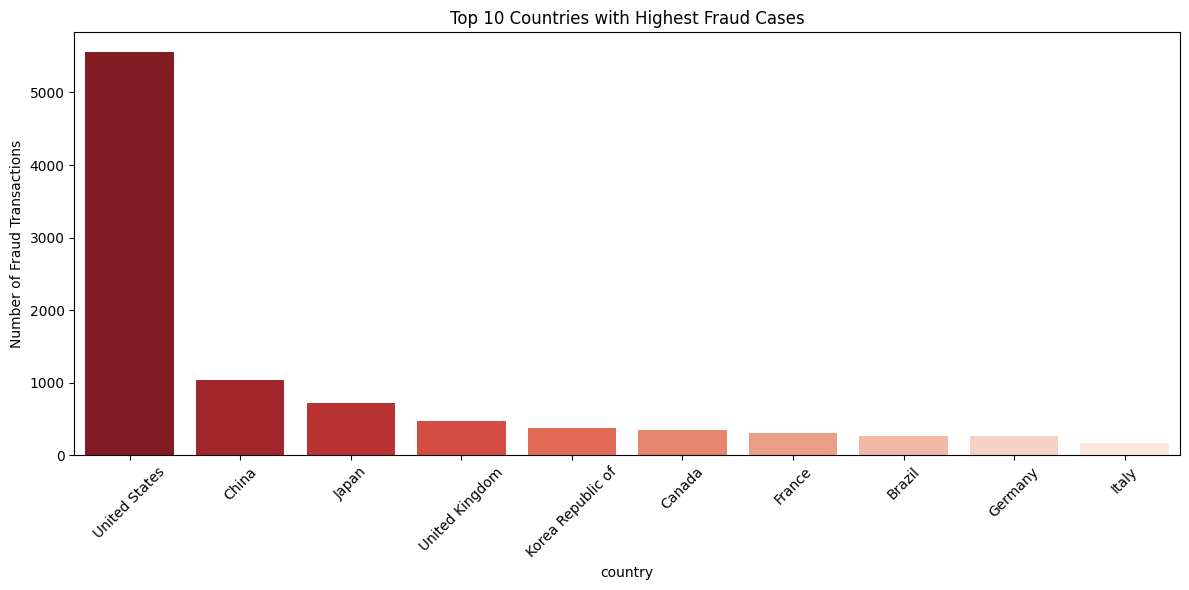

In [7]:
# --- PLOT 1: Fraud by Country (Fixed Warning) ---
plt.figure(figsize=(12, 6))
fraud_by_country = merged_df[merged_df['class'] == 1]['country'].value_counts().head(10)

# FIX: Added hue=fraud_by_country.index and legend=False
sns.barplot(x=fraud_by_country.index, y=fraud_by_country.values, hue=fraud_by_country.index, legend=False, palette="Reds_r")

plt.title("Top 10 Countries with Highest Fraud Cases")
plt.xticks(rotation=45)
plt.ylabel("Number of Fraud Transactions")
plt.tight_layout()
plt.savefig('fraud_by_country.png') 
plt.show()

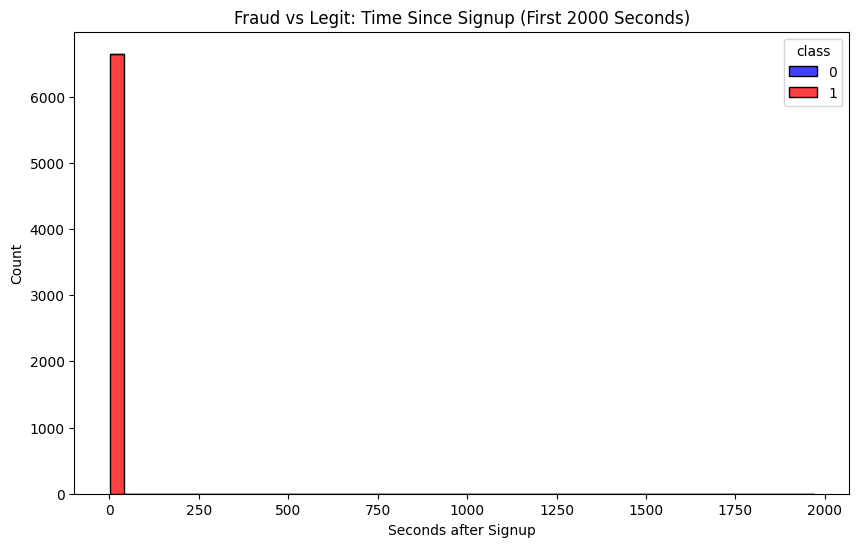

In [8]:
# --- PLOT 2: Time Since Signup (Zoomed to first 24 hours) ---
# We filter for transactions within the first 24 hours (86400 seconds) to see the bot spike
subset = merged_df[merged_df['time_since_signup'] < 2000] 

plt.figure(figsize=(10, 6))
sns.histplot(data=subset, x='time_since_signup', hue='class', bins=50, multiple="stack", palette={0: "blue", 1: "red"})
plt.title("Fraud vs Legit: Time Since Signup (First 2000 Seconds)")
plt.xlabel("Seconds after Signup")
plt.ylabel("Count")
plt.savefig('time_since_signup.png') 
plt.show()

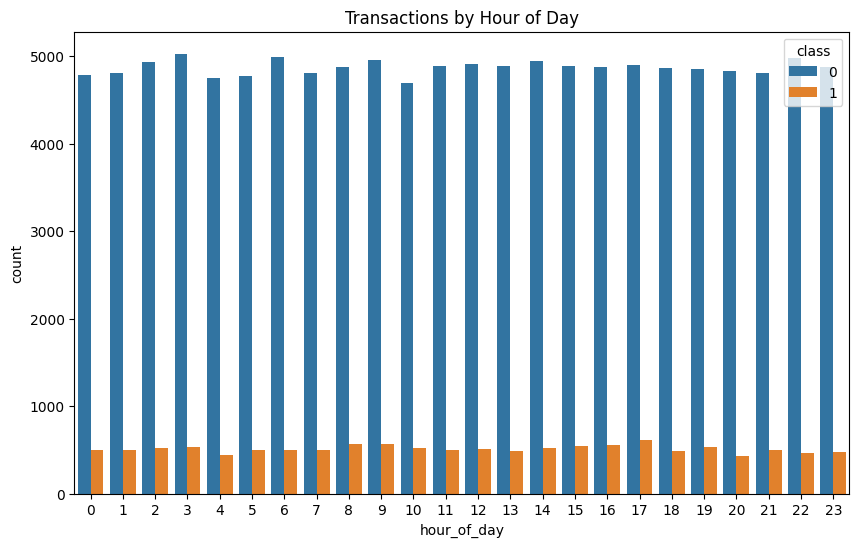

In [9]:
# --- PLOT 3: Fraud by Hour ---
plt.figure(figsize=(10, 6))
sns.countplot(x='hour_of_day', hue='class', data=merged_df)
plt.title("Transactions by Hour of Day")
plt.savefig('fraud_hour.png') # SAVE THIS IMAGE
plt.show()

In [10]:
# Save processed data for later
merged_df.to_csv('../data/processed/Fraud_Data_Merged.csv', index=False)
print("Done.")

Done.


In [11]:
# --- SUPER PATCH for Scikit-Learn 1.6+ Compatibility ---
import sklearn.utils.validation
import sklearn.ensemble

# Patch 1: Fix missing _is_pandas_df function
if not hasattr(sklearn.utils.validation, '_is_pandas_df'):
    sklearn.utils.validation._is_pandas_df = lambda x: hasattr(x, 'dtypes') and hasattr(x, 'columns')

# Patch 2: Fix AdaBoost algorithm parameter removal
OriginalAdaBoost = sklearn.ensemble.AdaBoostClassifier
class PatchedAdaBoost(OriginalAdaBoost):
    def __init__(self, *args, **kwargs):
        kwargs.pop('algorithm', None)
        super().__init__(*args, **kwargs)
sklearn.ensemble.AdaBoostClassifier = PatchedAdaBoost
# --- END PATCH ---

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

print("--- Preparing Data for Modeling ---")

# 1. Feature Engineering (The missing part!)
# We need to create this column before we can use it
device_freq = merged_df['device_id'].value_counts()
merged_df['device_transaction_count'] = merged_df['device_id'].map(device_freq)

# 2. Separate Target and Features
X = merged_df.drop(['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)
y = merged_df['class']

# 3. Define features
numeric_features = ['purchase_value', 'age', 'ip_address_int', 'time_since_signup', 'hour_of_day', 'day_of_week', 'device_transaction_count']
categorical_features = ['source', 'browser', 'sex', 'country']

# 4. Create Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Applying transformations (Scaling & Encoding)...")
X_train_transformed = preprocessor.fit_transform(X_train)

# 6. Apply SMOTE
print(f"Original Training Class Distribution: {y_train.value_counts().to_dict()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

print(f"Post-SMOTE Training Class Distribution: {y_train_resampled.value_counts().to_dict()}")

--- Preparing Data for Modeling ---
Applying transformations (Scaling & Encoding)...
Original Training Class Distribution: {0: 93502, 1: 9814}
Post-SMOTE Training Class Distribution: {0: 93502, 1: 93502}
